In [1]:
# Use seaborn for pairplot.
!pip install -q seaborn

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.8.0


### Get the data
First import the dataset using pandas:

In [4]:
#raw_dataset = pd.read_csv('G_datasets-AEA.csv')

In [5]:
raw_dataset = pd.read_csv('AG_G_dataset-PTC.csv')

In [6]:
dataset = raw_dataset.copy()
dataset.tail()

,DAT(days),Temp,WC,NL,N(PTC) (mg/g),P(PTC) (mg/g),K(PTC) (mg/g),Ca(PTC) (mg/g),Mg(PTC) (mg/g),S(PTC) (mg/g),Na(PTC) (mg/g),Diameter of Bulb(mm)
86,88,29.5,16.17,15.85,34.98,6.50,45.75,11.38,1.56,2.85,1.46,118.21
87,89,27.9,16.29,15.88,34.76,6.51,45.76,11.42,1.57,2.86,1.45,119.00
88,90,27.1,16.38,15.00,34.63,6.52,45.77,11.49,1.58,2.99,1.44,120.63
89,91,26.1,16.47,14.95,34.51,6.53,45.78,11.53,1.63,3.22,1.43,120.95
90,92,26.9,17.06,14.88,34.44,6.54,45.79,11.62,1.69,3.37,1.42,121.47


### Clean the data

The dataset contains a few unknown values:

In [7]:
dataset.isna().sum()

DAT(days)               0
Temp                    0
WC                      0
NL                      0
N(PTC) (mg/g)           0
P(PTC) (mg/g)           0
K(PTC) (mg/g)           0
Ca(PTC) (mg/g)          0
Mg(PTC) (mg/g)          0
S(PTC) (mg/g)           0
Na(PTC) (mg/g)          0
Diameter of Bulb(mm)    0
dtype: int64

Drop those rows to keep this initial tutorial simple:

In [8]:
dataset = dataset.dropna()

### Split the data into training and test sets

Now, split the dataset into a training set and a test set. You will use the test set in the final evaluation of your models.

In [9]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Review the joint distribution of a few pairs of columns from the training set.

The top row suggests that the Temperature is a function of all the other parameters. The other rows indicate they are functions of each other.

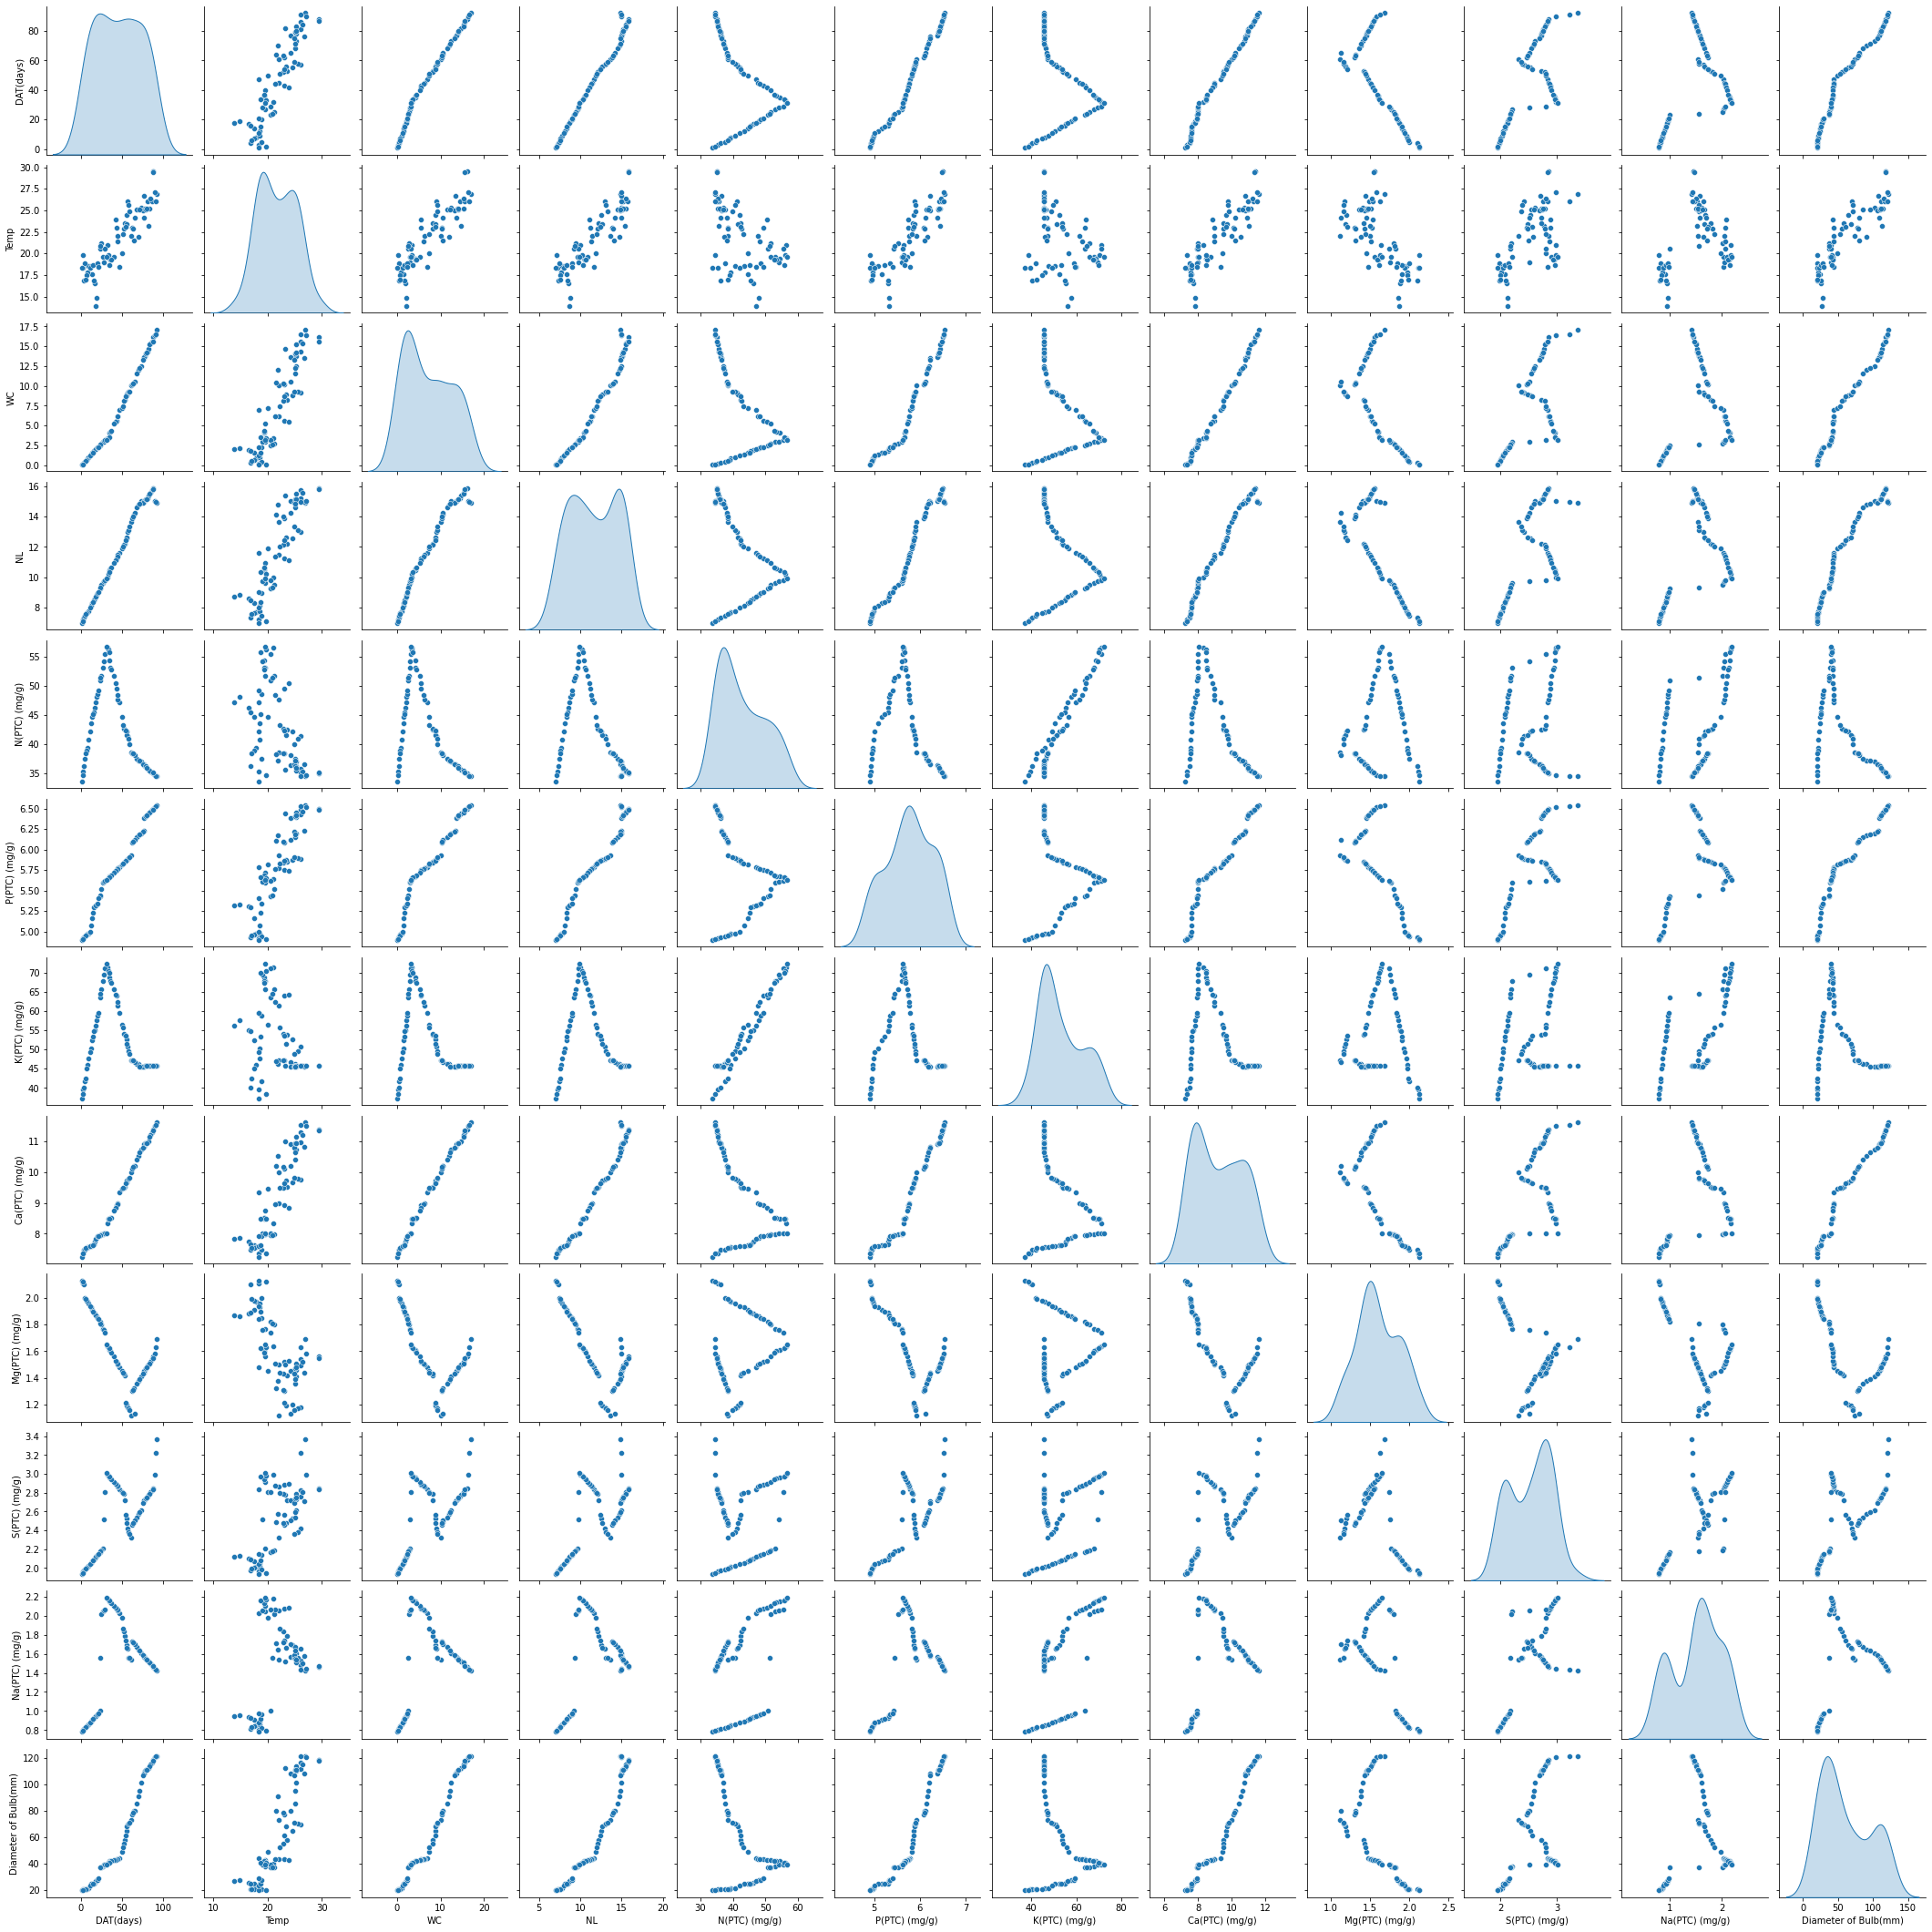

In [10]:
#sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')
sns.pairplot(train_dataset[['DAT(days)','Temp','WC','NL','N(PTC) (mg/g)','P(PTC) (mg/g)','K(PTC) (mg/g)','Ca(PTC) (mg/g)','Mg(PTC) (mg/g)','S(PTC) (mg/g)','Na(PTC) (mg/g)','Diameter of Bulb(mm)']]
             ,diag_kind='kde')


Let's also check the overall statistics. Note how each feature covers a very different range:

In [11]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
DAT(days),73.0,45.671233,27.571652,1.00,21.00,45.00,70.00,92.00
Temp,73.0,21.749315,3.490229,13.90,18.90,21.50,25.00,29.50
WC,73.0,7.203973,5.345232,0.08,2.31,6.20,12.01,17.06
NL,73.0,11.621096,2.849404,7.00,9.04,11.48,14.77,15.85
N(PTC) (mg/g),73.0,42.764932,6.998363,33.55,36.47,41.29,48.35,56.70
P(PTC) (mg/g),73.0,5.766027,0.498698,4.90,5.41,5.77,6.17,6.54
K(PTC) (mg/g),73.0,53.022877,9.438832,37.29,45.71,49.57,59.64,72.33
Ca(PTC) (mg/g),73.0,9.212466,1.387159,7.25,7.93,8.98,10.52,11.62
Mg(PTC) (mg/g),73.0,1.606068,0.265788,1.12,1.44,1.56,1.84,2.13
S(PTC) (mg/g),73.0,2.533151,0.369037,1.94,2.15,2.57,2.83,3.37


### Split features from labels

Separate the target value—the "label"—from the features. This label is the value that you will train the model to predict.

In [12]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Diameter of Bulb(mm)')
test_labels = test_features.pop('Diameter of Bulb(mm)')

## Normalization

In the table of statistics it's easy to see how different the ranges of each feature are:

In [13]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
DAT(days),45.671233,27.571652
Temp,21.749315,3.490229
WC,7.203973,5.345232
NL,11.621096,2.849404
N(PTC) (mg/g),42.764932,6.998363
P(PTC) (mg/g),5.766027,0.498698
K(PTC) (mg/g),53.022877,9.438832
Ca(PTC) (mg/g),9.212466,1.387159
Mg(PTC) (mg/g),1.606068,0.265788
S(PTC) (mg/g),2.533151,0.369037


It is good practice to normalize features that use different scales and ranges.

One reason this is important is because the features are multiplied by the model weights. So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

normalization makes training much more stable.

### The Normalization layer

The `tf.keras.layers.Normalization` is a clean and simple way to add feature normalization into your model.

The first step is to create the layer:

In [14]:
normalizer = tf.keras.layers.Normalization(axis=-1)

Then, fit the state of the preprocessing layer to the data by calling `Normalization.adapt`:

In [15]:
normalizer.adapt(np.array(train_features))

Calculate the mean and variance, and store them in the layer:

In [16]:
print(normalizer.mean.numpy())

[[45.671 21.749  7.204 11.621 42.765  5.766 53.023  9.212  1.606  2.533
   1.526]]


When the layer is called, it returns the input data, with each feature independently normalized:

In [17]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[ 3.   18.3   0.24  7.21 35.28  4.92 39.64  7.36  2.11  1.96  0.8 ]]

Normalized: [[-1.56 -1.   -1.31 -1.56 -1.08 -1.71 -1.43 -1.34  1.91 -1.56 -1.61]]


## Linear regression

Before building a deep neural network model, start with linear regression using one and several variables.

### Linear regression with one variable

Begin with a single-variable linear regression to predict 'Diameter of Bulb' from 'Number of Leaves(NL)'.

There are two steps in your single-variable linear regression model:

- Normalize the `'NL'` input features using the `tf.keras.layers.Normalization` preprocessing layer.
- Apply a linear transformation ($y = mx+b$) to produce 1 output using a linear layer (`tf.keras.layers.Dense`).

The number of _inputs_ can either be set by the `input_shape` argument, or automatically when the model is run for the first time.

First, create a NumPy array made of the `'NL'` features. Then, instantiate the `tf.keras.layers.Normalization` and fit its state to the `NL` data:

In [18]:
NL = np.array(train_features['NL'])

NL_normalizer = layers.Normalization(input_shape=[1,], axis=None)
NL_normalizer.adapt(NL)

Build the Keras Sequential model:

In [19]:
NL_model = tf.keras.Sequential([
    NL_normalizer,
    layers.Dense(units=1)
])

NL_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


This model will predict `'Diameter of Bulb'` from `'NL'`.

Run the untrained model on the first 10 'Horsepower' values. The output won't be good, but notice that it has the expected shape of `(10, 1)`:

In [20]:
NL_model.predict(NL[:5])

array([[-0.834],
       [-0.622],
       [ 0.177],
       [-0.066],
       [ 0.799]], dtype=float32)

Once the model is built, configure the training procedure using the Keras `Model.compile` method. The most important arguments to compile are the `loss` and the `optimizer`, since these define what will be optimized (`mean_absolute_error`) and how (using the `tf.keras.optimizers.Adam`).

In [21]:
NL_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Use Keras `Model.fit` to execute the training for 100 epochs:

In [22]:
%%time
history = NL_model.fit(
    train_features['NL'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Wall time: 1.72 s


Visualize the model's training progress using the stats stored in the `history` object:

In [23]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,38.952053,54.301006,95
96,38.779213,54.081097,96
97,38.593296,53.862549,97
98,38.422508,53.638241,98
99,38.242760,53.417252,99


In [24]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 300])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Diameter of Bulb(mm)]')
  plt.legend()
  plt.grid(True)

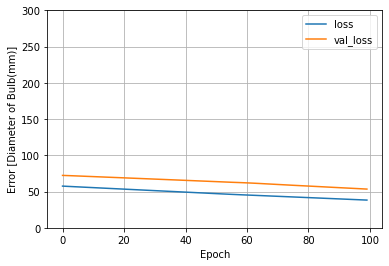

In [25]:
plot_loss(history)

Collect the results on the test set for later:

In [26]:
test_results = {}

test_results['NL_model'] = NL_model.evaluate(
    test_features['NL'],
    test_labels, verbose=0)

Since this is a single variable regression, it's easy to view the model's predictions as a function of the input:

In [27]:
x = tf.linspace(0.0, 12, 12)
y = NL_model.predict(x)

In [28]:
def plot_NL(x, y):
  plt.scatter(train_features['NL'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('NL')
  plt.ylabel('Diameter of Bulb(mm)')
  plt.legend()

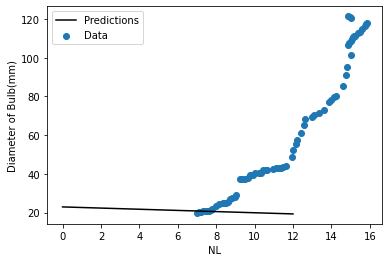

In [29]:
plot_NL(x, y)

### Linear regression with multiple inputs

You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same $y = mx+b$ except that $m$ is a matrix and $b$ is a vector.

Create a two-step Keras Sequential model again with the first layer being `normalizer` (`tf.keras.layers.Normalization(axis=-1)`) you defined earlier and adapted to the whole dataset:

In [30]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

When you call `Model.predict` on a batch of inputs, it produces `units=1` outputs for each example:

In [31]:
linear_model.predict(train_features[:6])

array([[ 2.321],
       [ 1.674],
       [-1.526],
       [ 0.533],
       [-3.107],
       [ 1.702]], dtype=float32)

When you call the model, its weight matrices will be built—check that the `kernel` weights (the $m$ in $y=mx+b$) have a shape of `(9, 1)`:

In [32]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(11, 1) dtype=float32, numpy=
array([[ 0.053],
       [-0.697],
       [-0.466],
       [ 0.081],
       [ 0.081],
       [-0.484],
       [-0.279],
       [-0.391],
       [ 0.527],
       [ 0.462],
       [ 0.448]], dtype=float32)>

Configure the model with Keras `Model.compile` and train with `Model.fit` for 100 epochs:

In [33]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [34]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Wall time: 1.68 s


Using all the inputs in this regression model achieves a much lower training and validation error than the `NL`, which had one input:

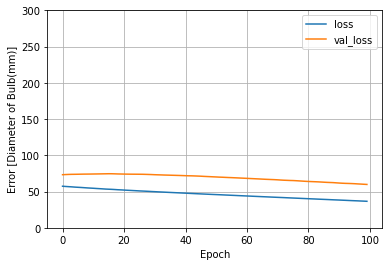

In [35]:
plot_loss(history)

Collect the results on the test set for later:

In [36]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

## Regression with a deep neural network (DNN)

In the previous section, you implemented two linear models for single and multiple inputs.

Here, you will implement single-input and multiple-input DNN models.

The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer, as before (with `NL_normalizer` for a single-input model and `normalizer` for a multiple-input model).
* Two hidden, non-linear, `Dense` layers with the ReLU (`relu`) activation function nonlinearity.
* A linear `Dense` single-output layer.

Both models will use the same training procedure so the `compile` method is included in the `build_and_compile_model` function below.

In [37]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(24, activation='relu'),
      layers.Dense(24, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.01))
  return model

### Regression using a DNN and a single input

Create a DNN model with only `'NL'` as input and `NL_normalizer` (defined earlier) as the normalization layer:

In [38]:
dnn_NL_model = build_and_compile_model(NL_normalizer)

This model has quite a few more trainable parameters than the linear models:

In [39]:
dnn_NL_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 24)                48        
                                                                 
 dense_3 (Dense)             (None, 24)                600       
                                                                 
 dense_4 (Dense)             (None, 1)                 25        
                                                                 
Total params: 676
Trainable params: 673
Non-trainable params: 3
_________________________________________________________________


Train the model with Keras `Model.fit`:

In [40]:
%%time
history = dnn_NL_model.fit(
    train_features['NL'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 1.74 s


This model does slightly better than the linear single-input `NL_model`:

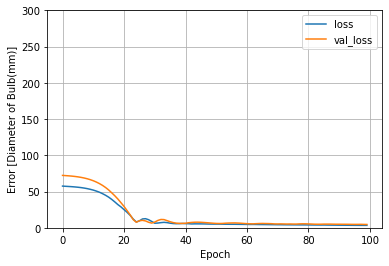

In [41]:
plot_loss(history)

If you plot the predictions as a function of `'NL'`, you should notice how this model takes advantage of the nonlinearity provided by the hidden layers:

In [42]:
x = tf.linspace(0.0, 12, 12)
y = dnn_NL_model.predict(x)

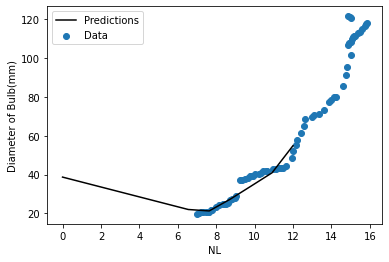

In [43]:
plot_NL(x, y)

Collect the results on the test set for later:

In [44]:
test_results['dnn_NL_model'] = dnn_NL_model.evaluate(
    test_features['NL'], test_labels,
    verbose=0)

### Regression using a DNN and multiple inputs

Repeat the previous process using all the inputs. The model's performance slightly improves on the validation dataset.

In [45]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 11)               23        
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 24)                288       
                                                                 
 dense_6 (Dense)             (None, 24)                600       
                                                                 
 dense_7 (Dense)             (None, 1)                 25        
                                                                 
Total params: 936
Trainable params: 913
Non-trainable params: 23
_________________________________________________________________


In [46]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 1.71 s


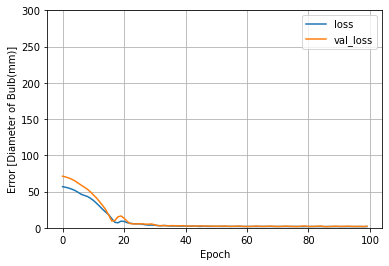

In [47]:
plot_loss(history)

Collect the results on the test set:

In [48]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

## Performance

Since all models have been trained, you can review their test set performance:

In [49]:
pd.DataFrame(test_results, index=['Mean absolute error [Diameter of Bulb(mm)]']).T

,Mean absolute error [Diameter of Bulb(mm)]
NL_model,44.823616
linear_model,42.913658
dnn_NL_model,4.443761
dnn_model,2.044808


These results match the validation error observed during training.

### Make predictions

You can now make predictions with the `dnn_model` on the test set using Keras `Model.predict` and review the loss:

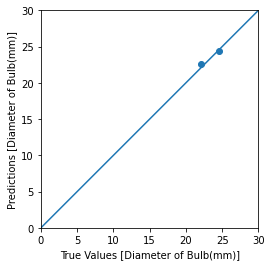

In [50]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Diameter of Bulb(mm)]')
plt.ylabel('Predictions [Diameter of Bulb(mm)]')
lims = [0, 30]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


It appears that the model predicts reasonably well.

Now, check the error distribution:

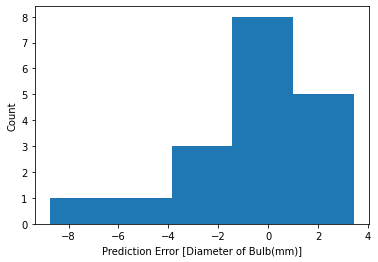

In [51]:
error = test_predictions - test_labels
plt.hist(error, bins=5)
plt.xlabel('Prediction Error [Diameter of Bulb(mm)]')
_ = plt.ylabel('Count')

If you're happy with the model, save it for later use with `Model.save`:

In [52]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model\assets


If you reload the model, it gives identical output:

In [53]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [54]:
(pd.DataFrame(test_results, index=['Mean absolute error [Diameter of Bulb(mm)]']).T)

,Mean absolute error [Diameter of Bulb(mm)]
NL_model,44.823616
linear_model,42.913658
dnn_NL_model,4.443761
dnn_model,2.044808
reloaded,2.044808


## Conclusion

This notebook introduced a few techniques to handle a regression problem. Here are a few more tips that may help:

- Mean squared error (MSE) (`tf.keras.losses.MeanSquaredError`) and mean absolute error (MAE) (`tf.keras.losses.MeanAbsoluteError`) are common loss functions used for regression problems. MAE is less sensitive to outliers. Different loss functions are used for classification problems.
- Similarly, evaluation metrics used for regression differ from classification.
- When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
- Overfitting is a common problem for DNN models, though it wasn't a problem for this tutorial. Visit the [Overfit and underfit](overfit_and_underfit.ipynb) tutorial for more help with this.

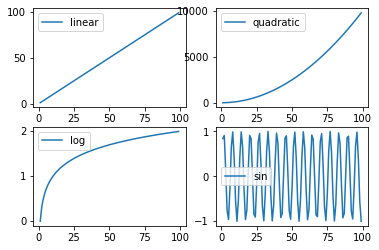

In [55]:
from cProfile import label

import matplotlib.pyplot as plt

import math



fig, axis = plt.subplots(nrows=2, ncols=2)




x = list(range(1,100))

y_1 = [ i for i in x]

y_2 = [ i**2 for i in x]

y_3 = [ math.log10(i) for i in x]

y_4 = [ math.sin(i) for i in x]



axis[0,0].plot(x,y_1, label='linear')

axis[0,0].legend()



axis[0,1].plot(x,y_2, label='quadratic')

axis[0,1].legend()



axis[1,0].plot(x,y_3, label='log')

axis[1,0].legend()



axis[1,1].plot(x,y_4, label='sin')

axis[1,1].legend()

In [56]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

In [57]:
df = pd.read_csv('AG_G_dataset-PTC.csv')
x = df.iloc[:,:-1].values
#y = df.iloc[:,1].values
y = df[['Diameter of Bulb(mm)']]
#x = [[0, 1], [5, 1], [15, 2], [25, 5], [35, 11], [45, 15], [55, 34], [60, 35] ]
#y = [4, 5, 20, 14, 32, 22, 38, 43]
x, y = np.array(x), np.array(y)
df

,DAT(days),Temp,WC,NL,N(PTC) (mg/g),P(PTC) (mg/g),K(PTC) (mg/g),Ca(PTC) (mg/g),Mg(PTC) (mg/g),S(PTC) (mg/g),Na(PTC) (mg/g),Diameter of Bulb(mm)
0,1,18.3,0.08,7.00,33.55,4.90,37.29,7.25,2.13,1.94,0.78,19.77
1,2,19.8,0.13,7.13,34.62,4.91,38.53,7.35,2.12,1.95,0.79,20.34
2,3,18.3,0.24,7.21,35.28,4.92,39.64,7.36,2.11,1.96,0.80,20.50
3,4,16.9,0.36,7.34,36.18,4.93,40.18,7.48,2.10,1.97,0.81,20.62
4,5,18.9,0.48,7.46,37.49,4.94,41.75,7.49,2.00,1.98,0.82,20.73
...,...,...,...,...,...,...,...,...,...,...,...,...
86,88,29.5,16.17,15.85,34.98,6.50,45.75,11.38,1.56,2.85,1.46,118.21
87,89,27.9,16.29,15.88,34.76,6.51,45.76,11.42,1.57,2.86,1.45,119.00
88,90,27.1,16.38,15.00,34.63,6.52,45.77,11.49,1.58,2.99,1.44,120.63
89,91,26.1,16.47,14.95,34.51,6.53,45.78,11.53,1.63,3.22,1.43,120.95


In [58]:
x = sm.add_constant(x)

In [59]:
# Create a model and fit it,The regression model based on ordinary least squares is an instance of the class statsmodels.
#regression.linear_model
model = sm.OLS(y, x)

In [60]:
# By calling .fit(), you obtain the variable results, which is an instance of the class statsmodels.
# regression.linear_model.RegressionResultsWrapper.
results = model.fit()

In [61]:
#call .summary() to get the table with the results of linear regression
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     756.3
Date:                Wed, 08 Jun 2022   Prob (F-statistic):           3.37e-75
Time:                        14:45:08   Log-Likelihood:                -236.99
No. Observations:                  91   AIC:                             498.0
Df Residuals:                      79   BIC:                             528.1
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -160.4224     75.203     -2.133      0.0

In [62]:
# To get rsquared, rsquared_adj, param
print(f"coefficient of determination: {results.rsquared}")
print(f"adjusted coefficient of determination: {results.rsquared_adj}")
print(f"regression coefficients: {results.params}")

coefficient of determination: 0.9905938594327147
adjusted coefficient of determination: 0.989284143657523
regression coefficients: [-160.422    0.036    1.197    6.4      1.809    4.199   22.235   -2.993
   -5.897   28.411   -8.296    4.383]


In [63]:
#To get predicted values for the input values
#print(f"predicted response:\n{results.fittedvalues}")
Bulb_pred = results.predict(x)
print(f"predicted response:\n{results.predict(x)}")

predicted response:
[ 17.976  20.453  18.83   19.547  21.046  21.164  16.325  17.26   20.391
  21.522  21.855  27.853  25.874  27.747  29.42   26.698  29.467  27.705
  28.582  32.585  34.58   32.892  33.285  36.069  38.18   36.709  38.296
  35.745  36.108  33.572  37.088  37.318  36.547  38.563  36.979  37.926
  44.377  44.515  43.55   43.589  47.845  44.387  46.018  46.979  52.566
  49.443  50.272  53.615  52.207  51.531  59.141  61.71   59.255  63.693
  64.139  70.495  72.089  70.135  66.532  69.475  79.577  80.357  79.959
  79.093  83.918  86.769  91.895  91.903  90.083  96.693  95.378  98.107
 100.37  100.793 104.17  104.71  106.957 108.566 108.805 111.103 109.099
 114.649 116.007 115.447 117.156 121.06  124.628 122.76  119.218 117.463
 121.89 ]


<function matplotlib.pyplot.show(close=None, block=None)>

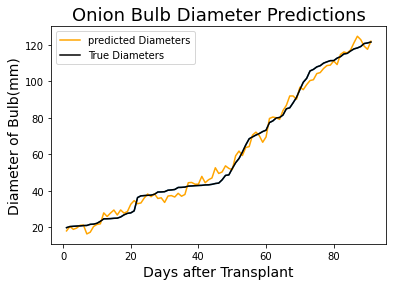

In [64]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(1, 92, 1)
#y = 
z = Bulb_pred
plt.plot(x, y)
plt.plot(x, z, color='orange', label='predicted Diameters')
plt.plot(x, y, color='black', label='True Diameters')
plt.ylabel('Diameter of Bulb(mm)', fontsize=14)
plt.xlabel('Days after Transplant', fontsize=14)

plt.title('Onion Bulb Diameter Predictions', fontsize=18)
plt.legend()
plt.show

In [67]:
!pip install rfpimp

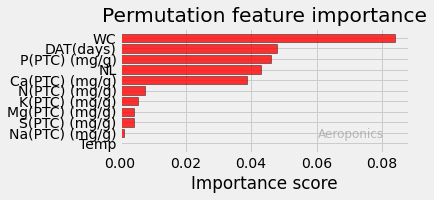

In [68]:
import rfpimp
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

######################################## Data preparation #########################################

#file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
#df = pd.read_csv(file)
features = ['DAT(days)','Temp','WC','NL','N(PTC) (mg/g)','P(PTC) (mg/g)','K(PTC) (mg/g)','Ca(PTC) (mg/g)','Mg(PTC) (mg/g)','S(PTC) (mg/g)','Na(PTC) (mg/g)','Diameter of Bulb(mm)']

######################################## Train/test split #########################################

df_train, df_test = train_test_split(df, test_size=0.20)
df_train = df_train[features]
df_test = df_test[features]

X_train, y_train = df_train.drop('Diameter of Bulb(mm)',axis=1), df_train['Diameter of Bulb(mm)']
X_test, y_test = df_test.drop('Diameter of Bulb(mm)',axis=1), df_test['Diameter of Bulb(mm)']

################################################ Train #############################################

rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(X_train, y_train)

############################### Permutation feature importance #####################################

imp = rfpimp.importances(rf, X_test, y_test)

############################################## Plot ################################################

fig, ax = plt.subplots(figsize=(6, 3))

ax.barh(imp.index, imp['Importance'], height=0.8, facecolor='red', alpha=0.8, edgecolor='k')
ax.set_xlabel('Importance score')
ax.set_title('Permutation feature importance')
ax.text(0.8, 0.15, 'Aeroponics', fontsize=12, ha='center', va='center',
        transform=ax.transAxes, color='grey', alpha=0.5)
plt.gca().invert_yaxis()

fig.tight_layout()